# Regularisation

An alternative to choosing models which contains smaller numbers of features is to use a method that *constrains* or *regularises* the coefficent estimates assigned to each feature, or that shrinks the coefficient towards zero. This technique is very similar to *least squares* which we have been using until now. Please refer to Section in 6.2 **ISTL** for a fuller explanation of this.

When we move to use a regularised linear regression for prediction the additional term means that we now have a model parameter that requires setting or tuning. These terms are referred to as *hyperparameters* in machine learning. In practice this introduces another additional unknown parameter which we must choose somewhere in our modelling. It is common practice to run several models, each with different values of this hyperparameter, and then assess the error of each using cross validation for comparison.

**Lasso vs Ridge** (just for information curiosity, no need to go in depth or spend to much time to understand the maths)

For now we will focus on how to implement Lasso and Ridge regression in sklearn. These are both types of regularised linear regression.

Lasso: objectif is to minimize
$$ RSS + \lambda \sum |\beta | $$
* can force coefficients exactly to zero: behaves thus as variable selection


Ridge: objectif is to minimize
$$ RSS + \lambda \sum \beta_i^2 $$
* does not force coefficients exactly to zero
* interestig when there are more predictors than observations

see further reading ILS, search for Ridge and Lasso

-----

In [21]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LinearRegression

from scipy.stats import linregress
import statsmodels.api as sm
import warnings


----

In [10]:
credit = pd.read_csv('./data/credit_modified.csv')
rating = credit.pop('Rating')
credit.shape
display(credit)
display(rating)

,Income,Limit,Cards,Age,Education,Gender,Student,Married,Balance,African American,Asian,Caucasian
0,14.891,3606,2,34,11,0,0,1,333,0,0,1
1,106.025,6645,3,82,15,1,1,1,903,0,1,0
2,104.593,7075,4,71,11,0,0,0,580,0,1,0
3,148.924,9504,3,36,11,1,0,0,964,0,1,0
4,55.882,4897,2,68,16,0,0,1,331,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
395,12.096,4100,3,32,13,0,0,1,560,0,0,1
396,13.364,3838,5,65,17,0,0,0,480,1,0,0
397,57.872,4171,5,67,12,1,0,1,138,0,0,1
398,37.728,2525,1,44,13,0,0,1,0,0,0,1


0      283
1      483
2      514
3      681
4      357
      ... 
395    307
396    296
397    321
398    192
399    415
Name: Rating, Length: 400, dtype: int64

mean --> 354.94
std ---> 154.72414259174906


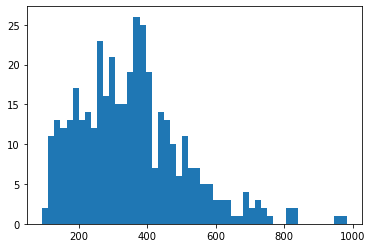

In [16]:
plt.hist(rating, bins=50);
print("mean -->",rating.mean())
print("std --->",rating.std())

## Lasso regression in sklearn

In this example we aim to predict credit rating of individual customers. To train and predict using a Lasso regression we follow much the same procedure as we have seen before in `scikit-learn`.

In [18]:
from sklearn.linear_model import Lasso

In [19]:
X_train, X_test, y_train, y_test = train_test_split(credit, rating, random_state = 91)

#### Creation Lasso model --> DIFFERENT DE LINEAR & CO <--

In [22]:
lasso = Lasso(alpha = 10)

mean MSE: 148.36580248151398
std MSE: 22.577610846122518


In [24]:
cv_scores = cross_val_score(lasso, X_train, y_train, cv = 5, scoring='neg_mean_squared_error')
print('mean MSE:',np.mean(-cv_scores))
print('std MSE:',np.std(-cv_scores))

mean MSE: 148.36580248151398
std MSE: 22.577610846122518


#### Importance of the Alpha parameter

In [30]:
alpha_list = []
MSE_mean_list = []
MSE_std_list = []


for alpha in range(5,100,5):
    lasso = Lasso(alpha = alpha)
    cv_scores = cross_val_score(lasso, X_train, y_train, cv = 5, scoring='neg_mean_squared_error')
    MSE_mean = np.mean(-cv_scores)
    MSE_std = np.std(-cv_scores)
    
    alpha_list.append(alpha)
    MSE_mean_list.append(MSE_mean)
    MSE_std_list.append(MSE_std)


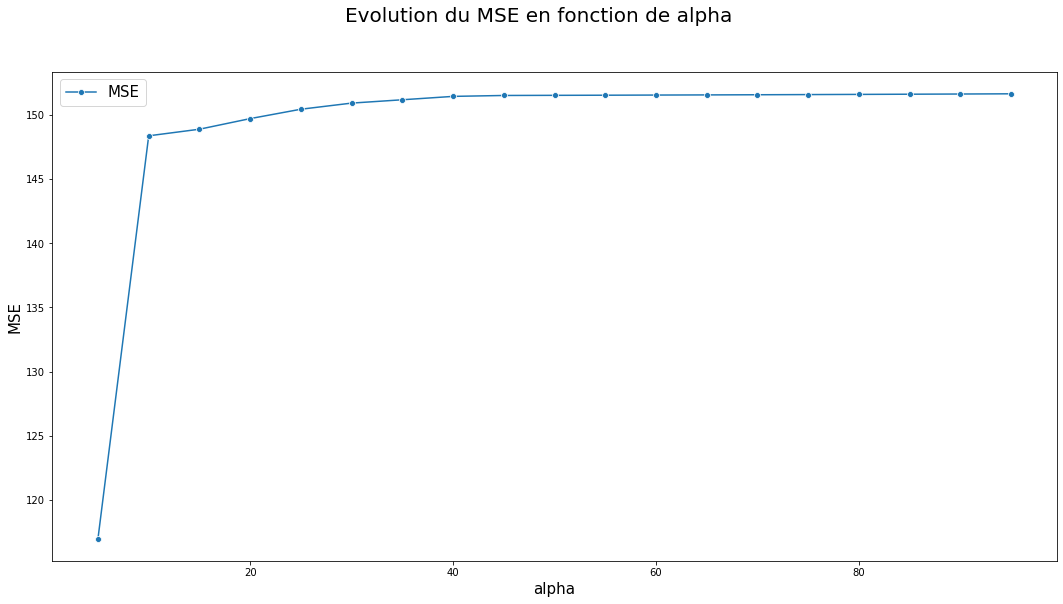

In [32]:
fig, ax = plt.subplots(figsize=(18,9))
fig.suptitle("Evolution du MSE en fonction de alpha", fontsize=20)

sns.lineplot(
    x = alpha_list, 
    y=MSE_mean_list,
    label="MSE",
    linestyle="-",
    marker = "o"
)

ax.set_xlabel("alpha", fontsize=15)
ax.set_ylabel("MSE", fontsize=15)
ax.legend(fontsize=15)

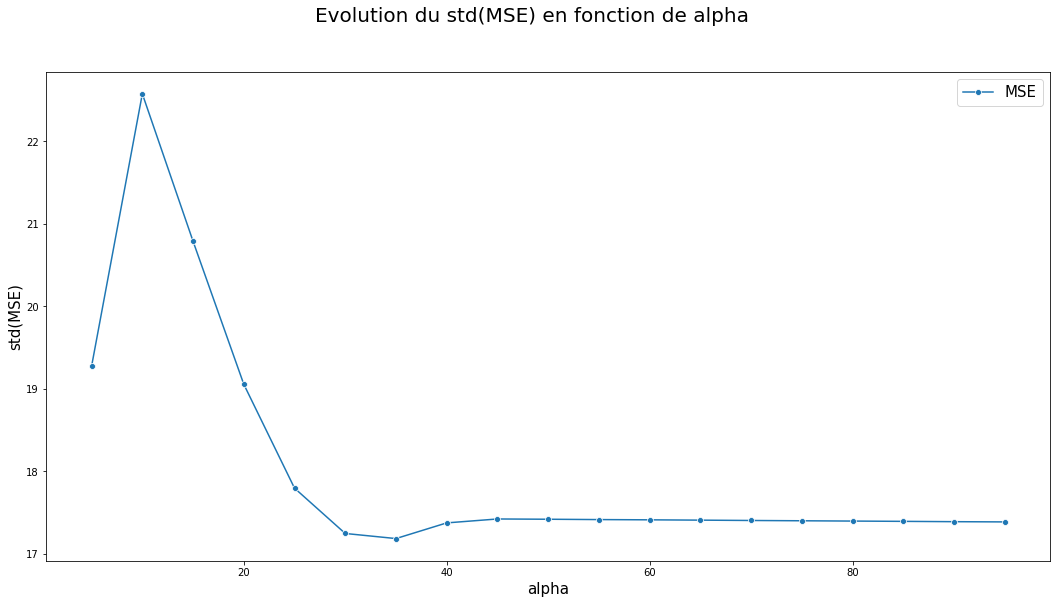

In [33]:
fig, ax = plt.subplots(figsize=(18,9))
fig.suptitle("Evolution du std(MSE) en fonction de alpha", fontsize=20)

sns.lineplot(
    x = alpha_list, 
    y=MSE_std_list,
    label="MSE",
    linestyle="-",
    marker = "o"
)

ax.set_xlabel("alpha", fontsize=15)
ax.set_ylabel("std(MSE)", fontsize=15)
ax.legend(fontsize=15)

#### Using Lasso with grid search

In practice we do not want to vary hyperparameters by hand to find which value is best (the model with minimum cross validation error). Of course `scikit-learn` has a function that automates this for you. Using `GridSearchCV` we pass a dictionary of parameter values we wish to investigate. The function will fit each model we have listed and calculate the cross validation error of each. It provides all the results through the object it returns.

In [34]:
from sklearn.model_selection import GridSearchCV
lasso = Lasso(max_iter=10000)

param_grid = [
 {'alpha': [0.001, 0.01, 0.1, 1, 3, 10, 100, 1000]}
 ]

grid_search = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

grid_results = pd.DataFrame(grid_search.cv_results_)

grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002737,0.000647,0.000755,0.000177,0.001,{'alpha': 0.001},-134.693531,-105.857049,-101.376944,-87.569097,-78.913304,-76.137420,-109.786540,-103.885686,-106.104721,-113.455931,-101.778022,16.450021,3
1,0.002004,0.000063,0.000574,0.000018,0.01,{'alpha': 0.01},-134.553201,-105.948212,-101.096381,-87.881139,-78.937345,-76.585584,-109.682491,-103.106018,-106.112572,-113.688788,-101.759173,16.329243,2
2,0.001520,0.000150,0.000568,0.000014,0.1,{'alpha': 0.1},-133.132694,-106.809300,-98.722275,-91.394863,-79.351692,-78.012317,-108.680986,-96.604537,-106.093953,-115.062267,-101.386489,15.688554,1
3,0.001295,0.000093,0.000665,0.000096,1,{'alpha': 1},-127.851853,-111.017555,-92.827631,-106.006184,-89.048154,-82.339570,-105.158164,-94.934777,-102.310102,-122.139519,-103.363351,13.605513,4
4,0.001142,0.000070,0.000581,0.000029,3,{'alpha': 3},-132.499698,-117.173048,-106.238114,-112.301661,-94.847286,-76.537019,-102.509314,-98.851062,-105.902336,-131.338637,-107.819817,15.910751,5


#### Best model

In [36]:
grid_search.best_estimator_

Lasso(alpha=0.1, max_iter=10000)

In [39]:
grid_search.best_index_
grid_search.cv_results_

{'mean_fit_time': array([0.0027374 , 0.00200374, 0.00151954, 0.00129488, 0.00114248,
        0.00103285, 0.00091951, 0.00088265]),
 'std_fit_time': array([6.46695005e-04, 6.25208845e-05, 1.49532103e-04, 9.26754485e-05,
        6.95462909e-05, 1.82253656e-05, 4.10613279e-06, 3.51447101e-06]),
 'mean_score_time': array([0.00075459, 0.00057397, 0.00056751, 0.00066547, 0.00058095,
        0.0005605 , 0.00055754, 0.00055914]),
 'std_score_time': array([1.77251154e-04, 1.78065961e-05, 1.38508883e-05, 9.58095554e-05,
        2.92789373e-05, 3.68963825e-06, 3.58144070e-06, 5.96408734e-06]),
 'param_alpha': masked_array(data=[0.001, 0.01, 0.1, 1, 3, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 1},
  {'alpha': 3},
  {'alpha': 10},
  {'alpha': 100},
  {'alpha': 1000}],
 'split0_test_score': array([-134.69353139, -134.553

SyntaxError: invalid syntax (726937909.py, line 1)